In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import rfft, rfftfreq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

from matplotlib.colors import LogNorm
from scipy.signal import spectrogram

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")

## Data: Synthetic audio signals (sine waves + noise)
We'll synthesize short audio clips (pure tones + noise). Each sample will be 1 second at 16kHz sample rate.

In [2]:
sr = 16000
duration_sec = 1.0
t = np.linspace(0, duration_sec, int(sr * duration_sec), endpoint=False)

def synth_tone(freq_hz, amplitude=0.7, noise_std=0.05):
    tone = amplitude * np.sin(2 * np.pi * freq_hz * t)
    noise = np.random.normal(0, noise_std, size=t.shape)
    return tone + noise

# create three example signals (low, mid, high frequency)
audio_signals = {
    'low_tone': synth_tone(220),    # A3-ish
    'mid_tone': synth_tone(880),    # A5-ish
    'high_tone': synth_tone(3000)   # high freq
}
print("Synthetic audio signals generated. Each length =", len(t))

Synthetic audio signals generated. Each length = 16000


## Basic Overview
Checks signal shapes, amplitude ranges, and ensures all have consistent sampling rate & duration.

In [3]:
# Quick sanity-preview
print("Number of audio clips:", len(audio_signals))
print("- Audio sample keys:", list(audio_signals.keys()))

for name, signal in audio_signals.items():
    print(f"{name}: length={len(signal)}, min={signal.min():.3f}, max={signal.max():.3f}, mean={signal.mean():.3f}")

Number of audio clips: 3
- Audio sample keys: ['low_tone', 'mid_tone', 'high_tone']
low_tone: length=16000, min=-0.844, max=0.853, mean=0.000
mid_tone: length=16000, min=-0.891, max=0.878, mean=0.000
high_tone: length=16000, min=-0.858, max=0.866, mean=0.000


## Waveform Visualization
* Helps you visually compare different frequencies and amplitude envelopes.
* High-frequency tones show faster oscillations, low tones slower waves.

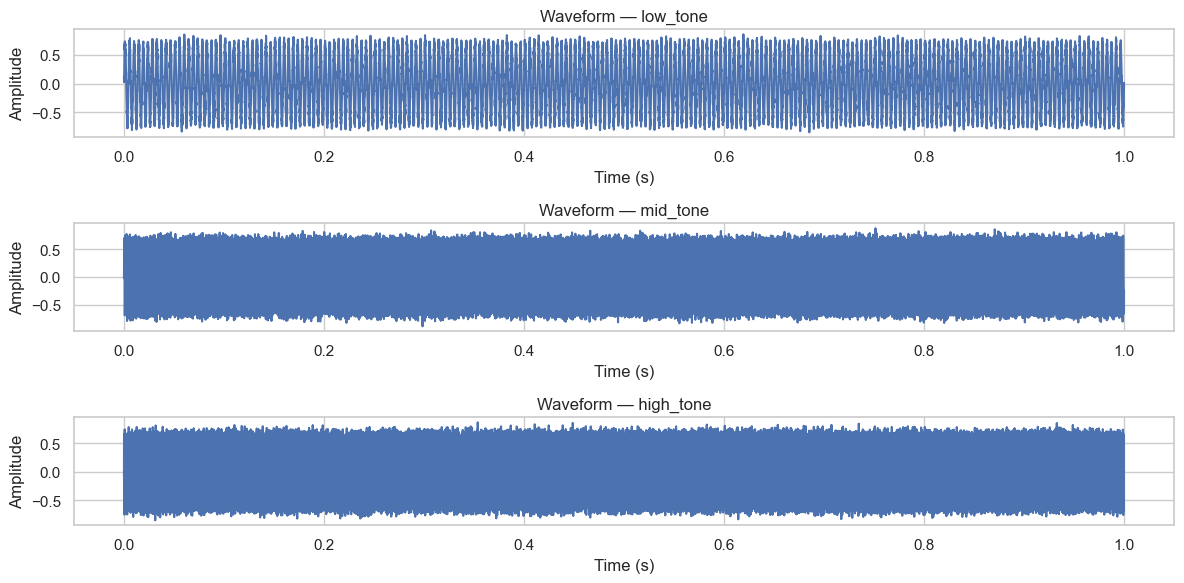

In [4]:
plt.figure(figsize=(12, 6))
for i, (name, signal) in enumerate(audio_signals.items(), 1):
    plt.subplot(3, 1, i)
    plt.plot(t, signal)
    plt.title(f"Waveform — {name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
plt.show()

## Frequency Domain (FFT Spectrum)

We’ll now analyze what frequencies are present in each signal — crucial for feature extraction.

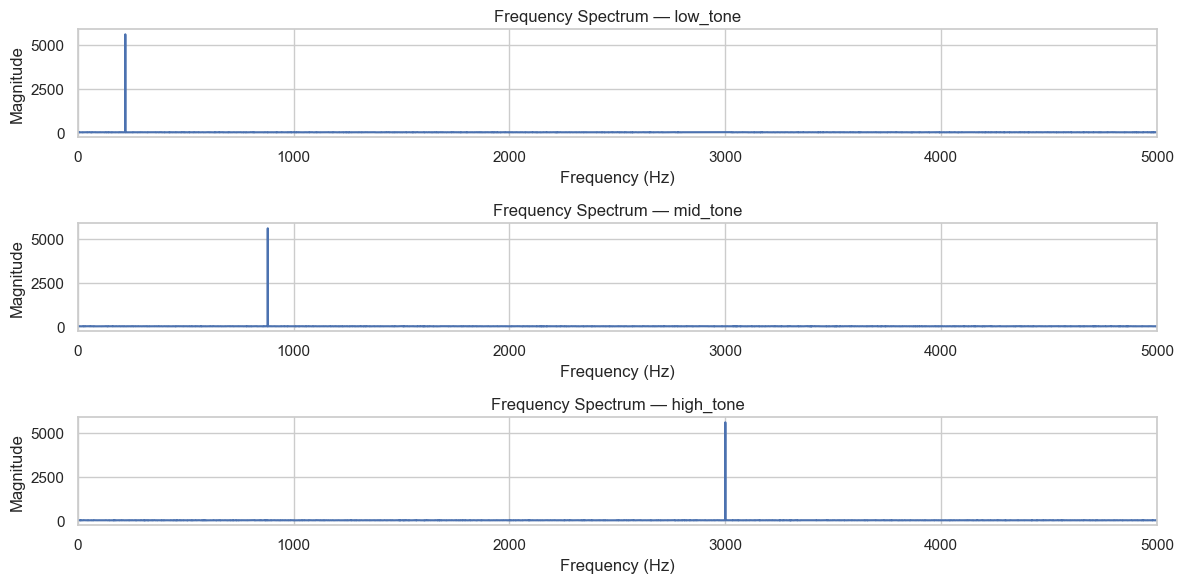

In [5]:
plt.figure(figsize=(12, 6))
for i, (name, signal) in enumerate(audio_signals.items(), 1):
    yf = np.abs(rfft(signal))
    xf = rfftfreq(len(signal), 1/sr)
    plt.subplot(3, 1, i)
    plt.plot(xf, yf)
    plt.xlim(0, 5000)   # up to 5 kHz for clarity
    plt.title(f"Frequency Spectrum — {name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.tight_layout()
plt.show()

Reveals dominant frequencies — you’ll clearly see peaks near 220 Hz, 880 Hz, and 3000 Hz, confirming our synthetic tones.

## Spectrogram Visualization

Now we visualize frequency vs time — this is what most audio deep learning models use (e.g., CNNs on Mel-Spectrograms).

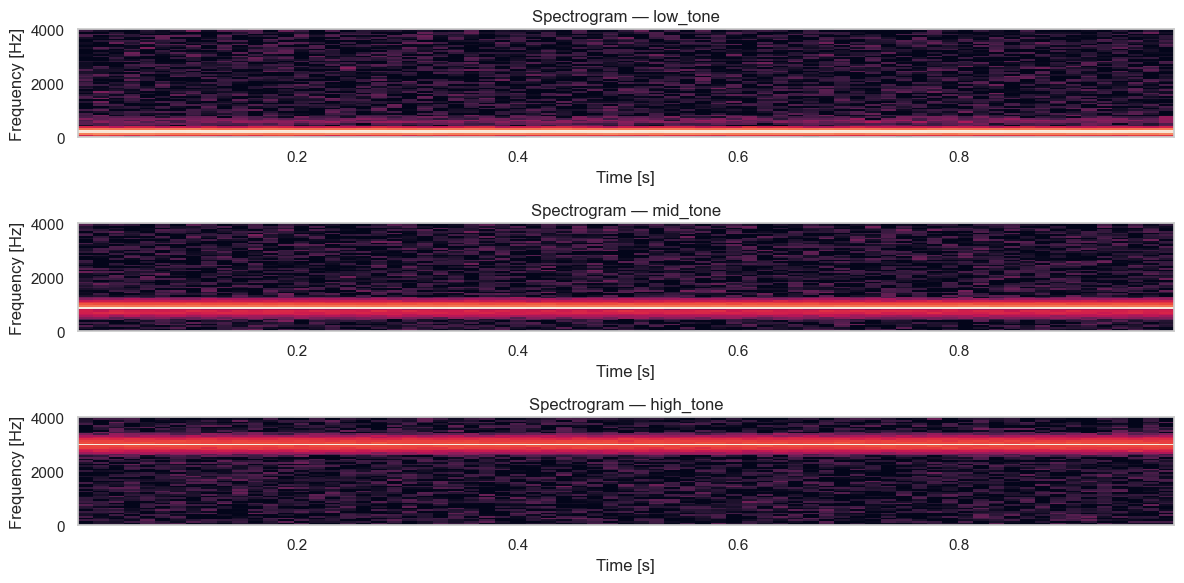

In [6]:
plt.figure(figsize=(12, 6))
for i, (name, signal) in enumerate(audio_signals.items(), 1):
    f, t_spec, Sxx = spectrogram(signal, sr)
    plt.subplot(3, 1, i)
    plt.pcolormesh(t_spec, f, Sxx, shading='auto', norm=LogNorm(vmin=1e-7, vmax=Sxx.max()))
    plt.title(f"Spectrogram — {name}")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [s]")
    plt.ylim(0, 4000)
    plt.tight_layout()
plt.show()

Spectrograms reveal how frequency energy evolves — here they’ll look like horizontal bright lines (stable tones).

## Feature Extraction Example (MFCC)

Mel-Frequency Cepstral Coefficients (MFCCs) are the gold-standard features for speech & sound classification.

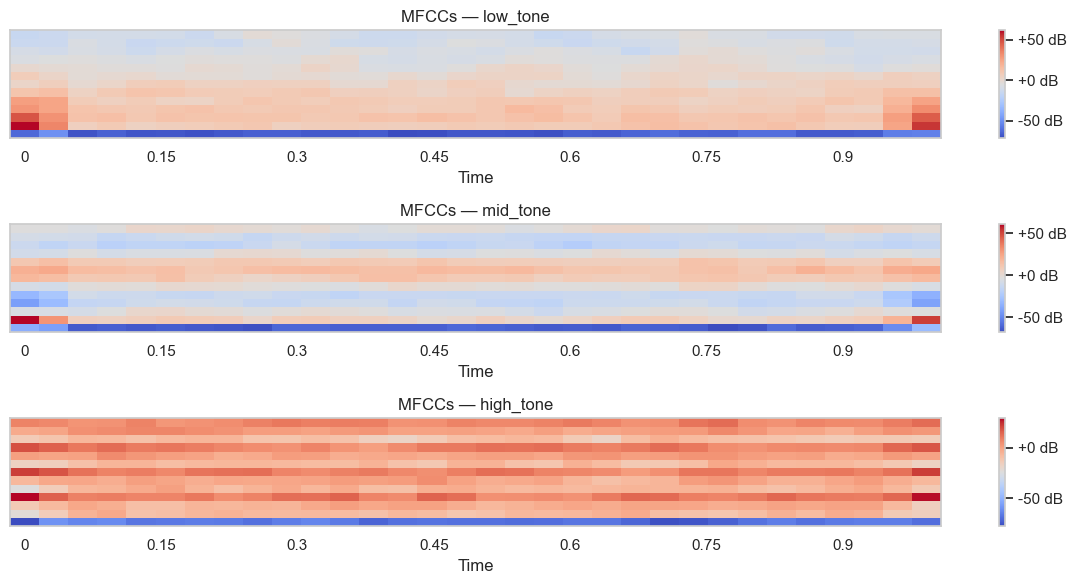

In [7]:
plt.figure(figsize=(12, 6))
for i, (name, signal) in enumerate(audio_signals.items(), 1):
    mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=sr, n_mfcc=13)
    plt.subplot(3, 1, i)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"MFCCs — {name}")
plt.tight_layout()
plt.show()

MFCCs compress spectral information into compact, perceptually relevant features — these are usually fed into ML/DL models.

## Feature Statistics Summary

We can summarize features numerically (useful before model training).
Each column represents an average spectral fingerprint of that signal — great for clustering, similarity, or classification.

In [8]:
mfcc_summary = {}
for name, signal in audio_signals.items():
    mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=sr, n_mfcc=13)
    mfcc_summary[name] = np.mean(mfccs, axis=1)

df_mfcc = pd.DataFrame(mfcc_summary)
print("Mean MFCC Features per Signal:")
display(df_mfcc)

Mean MFCC Features per Signal:


,low_tone,mid_tone,high_tone
0,-65.504015,-59.996833,-67.860830
1,13.008740,9.599997,-8.434594
2,15.038411,-4.323506,-4.107401
3,11.483107,-15.131643,10.769504
4,9.696964,-14.704052,-6.747201
5,7.308218,-2.069812,-2.013947
6,3.111911,10.200245,9.696819
7,0.716854,15.046277,-8.783534
8,-2.491546,9.234154,0.199195
9,-5.348953,-4.265366,9.105838


## Simple Similarity-Based Baseline Model
Since we only have three synthetic tones (low, mid, high), we'll perform a lightweight classification using MFCC mean vectors.

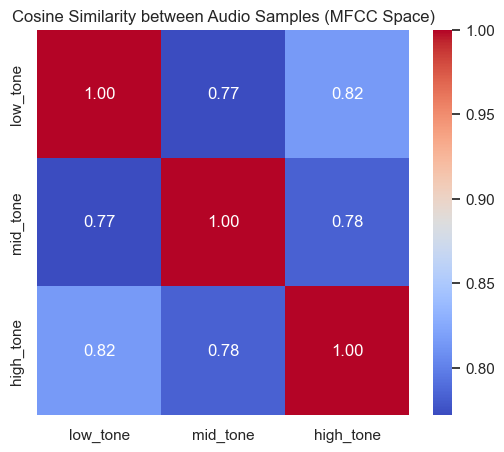

In [9]:
# Prepare feature matrix
X = df_mfcc.T.values   # each row = one sample's mean MFCC vector
labels = np.array(df_mfcc.columns)

# Compute similarity between every pair
sim_matrix = cosine_similarity(X)

plt.figure(figsize=(6,5))
sns.heatmap(sim_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap='coolwarm', fmt=".2f")
plt.title("Cosine Similarity between Audio Samples (MFCC Space)")
plt.show()

* Low and mid tones will have smaller similarity (~0.5–0.7)
* Mid and high tones are even more distinct — showing MFCCs capture pitch/frequency information effectively.

## t-SNE Visualization of Audio Feature Space
Let's visualize MFCC features in 2D space — useful for unsupervised analysis.

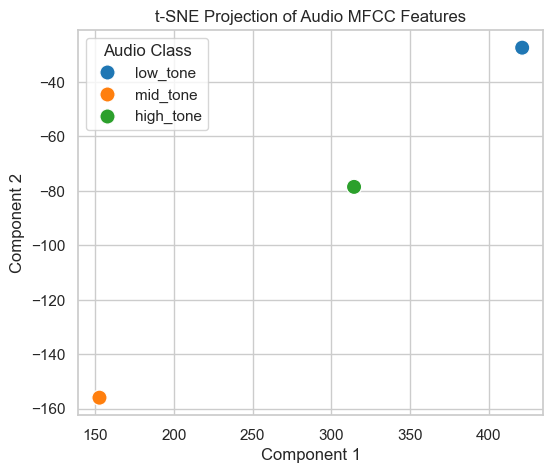

In [10]:
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels, s=120, palette='tab10')
plt.title("t-SNE Projection of Audio MFCC Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Audio Class")
plt.show()

We can see that similar tones cluster together — 
confirming that spectral features (MFCCs) carry strong frequency identity.

## Baseline Classification Example
We'll simulate a mini training set using multiple synthetic tones per class to classify frequencies.

In [11]:
def synth_dataset(num_per_class=20):
    freqs = {'low': 220, 'mid': 880, 'high': 3000}
    X, y = [], []
    for label, f in freqs.items():
        for _ in range(num_per_class):
            sig = synth_tone(f)
            mfccs = librosa.feature.mfcc(y=sig.astype(float), sr=sr, n_mfcc=13)
            X.append(np.mean(mfccs, axis=1))
            y.append(label)
    return np.array(X), np.array(y)

X_all, y_all = synth_dataset()
print("Synthetic dataset for baseline classification:", X_all.shape)

Synthetic dataset for baseline classification: (60, 13)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42, stratify=y_all)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Baseline Audio Classification Accuracy: {acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Baseline Audio Classification Accuracy: 1.000

Classification Report:
               precision    recall  f1-score   support

        high       1.00      1.00      1.00         6
         low       1.00      1.00      1.00         6
         mid       1.00      1.00      1.00         6

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



## Confusion Matrix Visualization

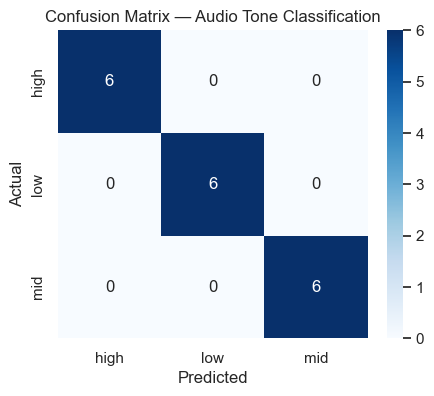

In [13]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_all), yticklabels=np.unique(y_all))
plt.title("Confusion Matrix — Audio Tone Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()